In [38]:
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.applications import EfficientNetB7
from keras import Model
from annoy import AnnoyIndex
from scipy import spatial
from keras.models import load_model

% matplotlib inline

In [39]:
ref_id = []
score = []
reference_id = []  #reference matching query
query_id = []

In [40]:
def store_query(path):
    for entry in os.listdir(path):
        file_name = os.path.basename(entry)
        file_name_without_extension = os.path.splitext(file_name)[0]
        query_id.append(file_name_without_extension)


def image_loader(folder):
    images = []
    for filename in os.listdir(folder):
        img = load_img(os.path.join(folder, filename), target_size=(224, 224))
        ref_id.append(os.path.basename(filename))
        img = img_to_array(img)
        img = img.reshape((1,) + img.shape)
        if img is not None:
            images.append(img)
    return images


def get_all_images():
    images = image_loader(r'C:\Users\harsh\OneDrive\Desktop\reference images')
    array_of_images = np.array([images])
    return array_of_images


def create_model():
    ENB7 = EfficientNetB7(include_top=True)
    model = Model(ENB7.input, ENB7.layers[-2].output)
    model.save('ENB7.h5')
    return model


def get_preds(array_of_images):
    preds_all = np.zeros((len(array_of_images), 2560))
    for j in range(array_of_images.shape[0]):
        preds_all[j] = model.predict(array_of_images[j])
    return preds_all


def load_model_from_path(filepath):
    return load_model(filepath)


def load_images_preds(numpy_filepath):
    data = np.load(numpy_filepath)
    img = data['images']
    preds = data['preds']
    return img, preds


def show_img(array):
    array = array.reshape(224, 224, 3)
    numpy_image = img_to_array(array)
    plt.imshow(np.uint8(numpy_image))
    plt.show()


def load_images_from_directory(filepath):
    img = load_img(filepath, target_size=(224, 224))
    img = img_to_array(img)
    img = img.reshape((1,) + img.shape)
    return img

In [41]:
def get_nearest_neighbor_and_similarity(preds, K):
    dims = 2560
    n_nearest_neighbors = K + 1
    trees = 10000
    file_index_to_file_vector = {}

    # build ann index
    t = AnnoyIndex(dims)
    for i in range(preds.shape[0]):
        file_vector = preds[i]
        file_index_to_file_vector[i] = file_vector
        t.add_item(i, file_vector)
    t.build(trees)

    for i in range(preds.shape[0]):
        master_vector = file_index_to_file_vector[i]
        similarities = []
        nearest_neighbors = t.get_nns_by_item(i, n_nearest_neighbors)

    for j in nearest_neighbors:
        #print (j)
        neighbor_vector = preds[j]
        similarity = 1 - spatial.distance.cosine(master_vector, neighbor_vector)
        rounded_similarity = int((similarity * 10000)) / 10000.0
        similarities.append(rounded_similarity)
    return similarities, nearest_neighbors

In [42]:
def get_similar_images(similarities, nearest_neighbors, images1):
    j = 0
    for i in nearest_neighbors:
        show_img(images1[i])
        print(similarities[j])
        j += 1

In [43]:
def main(new_image_file, model_file, image_pred_file, K):
    model = load_model_from_path(model_file)
    images, preds = load_images_preds(image_pred_file)
    new_images = load_images_from_directory(new_image_file)
    predicted_images = model.predict(new_images)
    images1 = np.append(images, new_images.reshape(1, 1, 224, 224, 3), axis=0)
    preds1 = np.append(preds, predicted_images, axis=0)
    similarities, nearest_neighbors = get_nearest_neighbor_and_similarity(preds1, K)
    score.append(similarities[1])
    reference_id.append(ref_id[nearest_neighbors[1]])
    get_similar_images(similarities, nearest_neighbors, images1)

In [44]:
def get_metrics(query_id, reference_id, score):
    df = pd.DataFrame()
    df['query_id'] = pd.Series(query_id)
    df['reference_id'] = pd.Series(reference_id)
    df['score'] = pd.Series(score)
    df.to_excel('result.xlsx', index=False)

<ipython-input-41-83cba11a4e0f>:8: FutureWarning: The default argument for metric will be removed in future version of Annoy. Please pass metric='angular' explicitly.
  t = AnnoyIndex(dims)


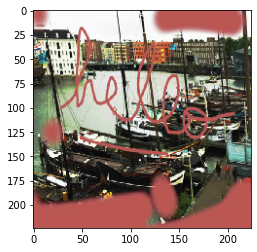

1.0


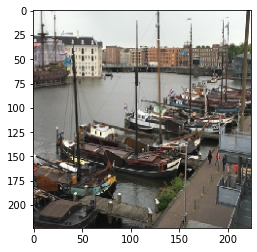

0.5659


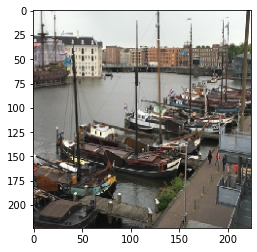

1.0


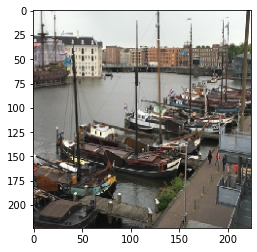

1.0


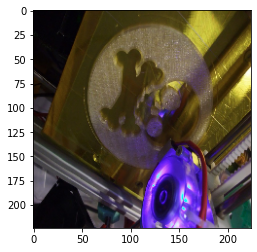

1.0


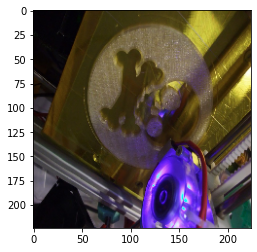

1.0


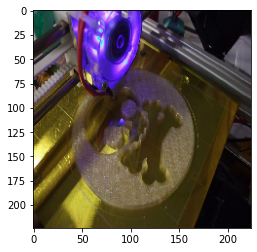

1.0


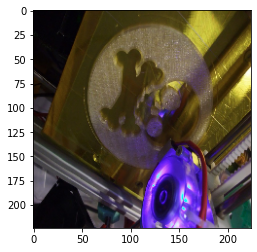

0.8446


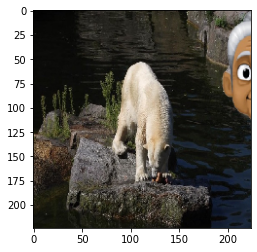

1.0


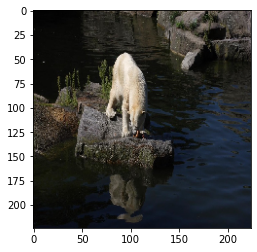

0.7371


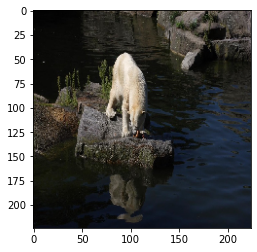

1.0


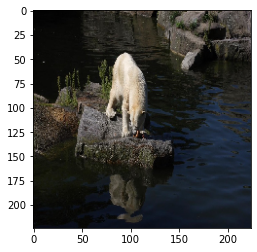

1.0


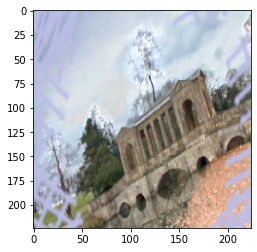

1.0


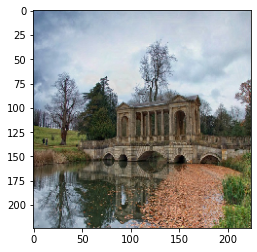

0.7625


In [ ]:
if __name__ == '__main__':
    all_imgs_arr = get_all_images()
    all_imgs_arr = all_imgs_arr.reshape(all_imgs_arr.shape[1], 1, 224, 224, 3)
    np.save('all_images_effb7', all_imgs_arr)
    model = create_model()
    preds_all = get_preds(all_imgs_arr)
    np.savez('images_preds_effb7', images=all_imgs_arr, preds=preds_all)
    model_file_path = r'C:\Users\harsh\effb7.h5'
    image_pred_path = r'C:\Users\harsh\images_preds_effb7.npz'
    query_path = r'C:\Users\harsh\Downloads\DMA'
    store_query(query_path)
    for file in os.listdir(query_path):
        t_path = os.path.join(query_path, file);
        main(t_path, model_file_path, image_pred_path, 1)
    get_metrics(query_id, reference_id, score)